# COVID Global Forecast: SIR model + ML regressions

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1), in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19.

**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)

    1.1. [COVID-19 global tendency excluding China](#section11)
    
    1.2. [COVID-19 tendency in China](#section12)
    
    1.3. [Italy, Spain, UK and Singapore](#section13)
    
2. [SIR model](#section2)

    2.1. [Implementing the SIR model](#section21)
    
    2.2. [Fit SIR parameters to real data](#section22)
    
3. [Data enrichment](#section3)

    3.1. [Join data, filter dates and clean missings](#section31)
    
    3.2. [Compute lags and trends](#section32)
    
    3.3. [Add country details](#section33)
    
4. [Predictions with machine learning](#section4)

    4.1. [Linear Regression for one country](#section41)
    
    4.2. [Logistic Regression for all countries (method 1)](#section42)
    
    4.3. [Logistic Regression for all countries (method 2)](#section43)
    
    4.4. [Logistic regression with lags](#section44)
    
5. [Statement of the author](#section5)

**Disclaimer 1**: this notebook is being updated frequently with the objective of improving predictions by using new models.

**Disclaimer 2**: the training dataset is also updated on a daily basis in order to include the most recent cases. In order to be up to date and prevent data leaking and other potential problems, daily updates on "filtered dates" will be applied.

**Disclaimer 3**: the COVID Global Forecasting competition is updated week by week (with a new competition). I'll move the notebook from previous weeks to the new one, so that it only appears in the most recent competition. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

# 1. Exploratory data analysis (EDA) <a id="section1"></a>

First of all, let's take a look on the data structure:

In [2]:
submission_example = pd.read_csv("../input/covid19-global-forecasting-week-2/submission.csv")
test = pd.read_csv("../input/covid19-global-forecasting-week-2/test.csv")
train = pd.read_csv("../input/covid19-global-forecasting-week-2/train.csv")
display(train.head(5))
display(train.describe())
print("Number of Country_Region: ", train['Country_Region'].nunique())
print("Dates go from day", max(train['Date']), "to day", min(train['Date']), ", a total of", train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", train[train['Province_State'].isna()==False]['Country_Region'].unique())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952
std,8487.230117,4541.261768,287.758197
min,1.000000,0.000000,0.000000
25%,7335.750000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000
max,29370.000000,105792.000000,12428.000000


Number of Country_Region:  173
Dates go from day 2020-03-31 to day 2020-01-22 , a total of 70 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


The dataset covers 163 countries and almost 2 full months from 2020, which is enough data to get some clues about the pandemic. Let's see a few plots of the worldwide tendency to see if we can extract some insights:

Text(0.5, 0, 'Date')

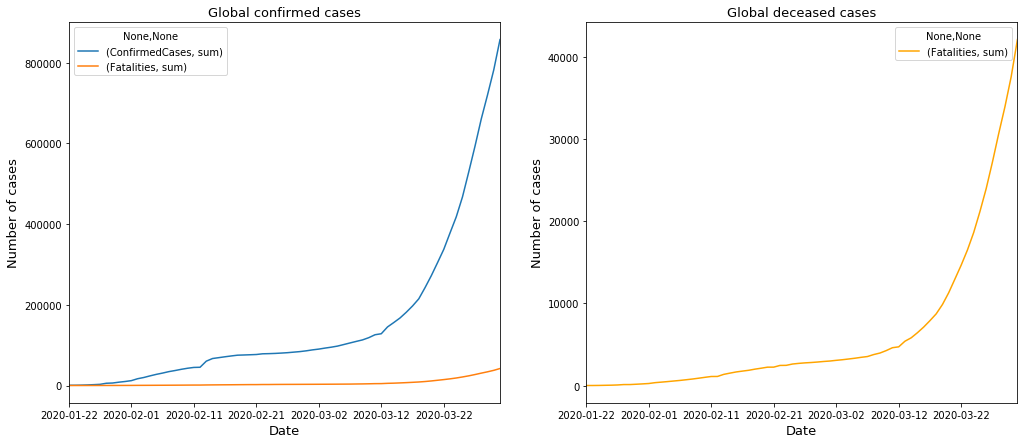

In [3]:
#confirmed_country = train.groupby(['Country/Region', 'Province/State']).agg({'ConfirmedCases':['sum']})
#fatalities_country = train.groupby(['Country/Region', 'Province/State']).agg({'Fatalities':['sum']})
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: The global curve shows a rich fine structure, but these numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact,  the criteria to consider infection cases was modified around 2020-02-11, which strongly perturbed the curve as you can see from the figure. 

## 1.1. COVID-19 global tendency excluding China <a id="section11"></a>

Since details of the initial breakthrough strongly interfere with the results, it's recomended to analyze China independently. Let's first see the results without China: 

Text(0.5, 0, 'Date')

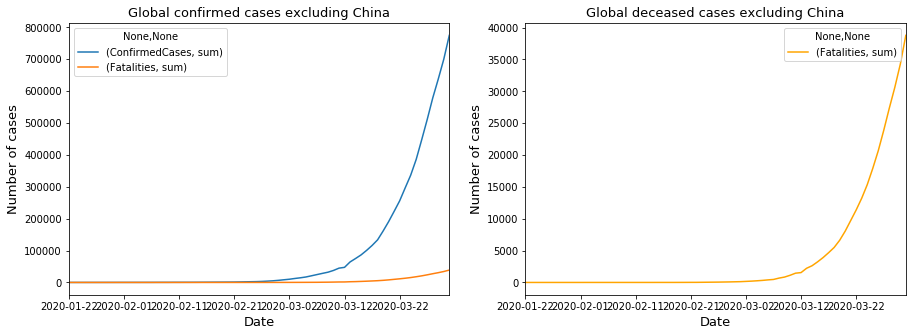

In [4]:
#confirmed_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_noChina = train[train['Country_Region']!='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country_Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf). SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. For comparison, a SIR simulation from section [2. SIR model](#section2):

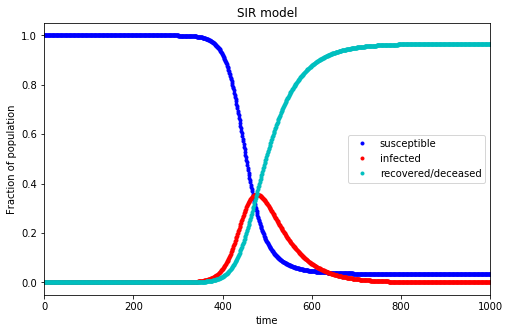

## 1.2. COVID-19 tendency in China <a id="section12"></a>

Since China was the initial infected country, the COVID-19 behavior is different from the rest of the world. The medical system was not prepared for the pandemic, in fact no one was aware of the virus until several cases were reported. Moreover, China government took strong contention measures in a considerable short period of time and, while the virus is widely spread, they have been able to control the increasing of the infections. 

Text(0.5, 0, 'Date')

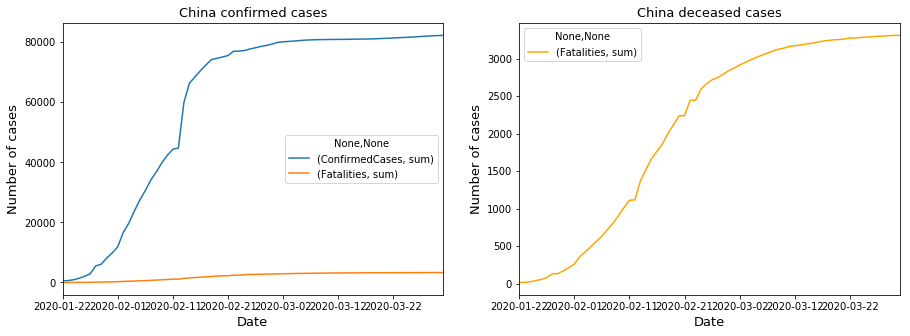

In [5]:
#confirmed_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_China = train[train['Country_Region']=='China'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("China deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**:

* **Smoothness**. Both plots are less smooth than theoretical simulations or the curve from the rest of the world cumulative
* **Infected criteria**. The moment in which the criteria to consider an infected case was changed is direclty spotted
* **Irregularities**. There are some iregularities. I should check the literature in depth to look for evidences, but the reasons may be that both the resources spent to monitor the epidemy and the security measures to stop ot have been changing over time
* **Plateaux**. It looks like the curve has reached a plateaux, which would imply that China is on their maximum of contagion 

## 1.3. Italy, Spain, UK and Singapore <a id="section13"></a>

Both Italy and Spain are experiencing the larger increase in COVID-19 positives in Europe. At the same time, UK is a unique case given that it's one of the most important countries in Europe but recently has left the European Union, which has create an effective barrier to human mobility from other countries. The fourth country we will study in this section is Singapore, since it's an asiatic island, is closer to China and its  socio-economic conditions is different from the other three countries.

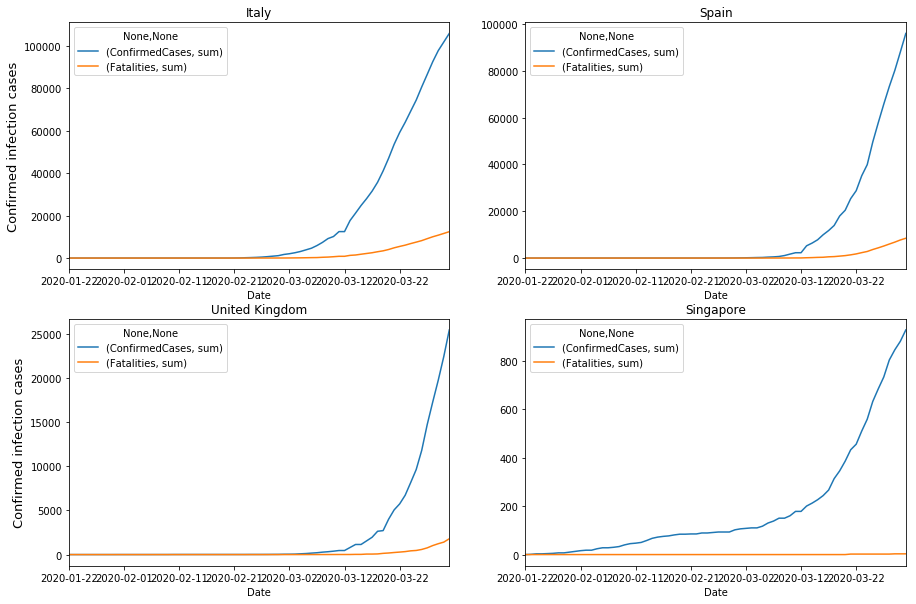

In [6]:
#confirmed_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[train['Country_Region']=='Italy'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country_Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[train['Country_Region']=='Spain'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country_Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country_Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[train['Country_Region']=='Australia'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[train['Country_Region']=='Australia'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[train['Country_Region']=='Singapore'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_Singapore.plot(ax=plt.gca(), title='Singapore')

As a fraction of the total population of each country:

(0, 0.005)

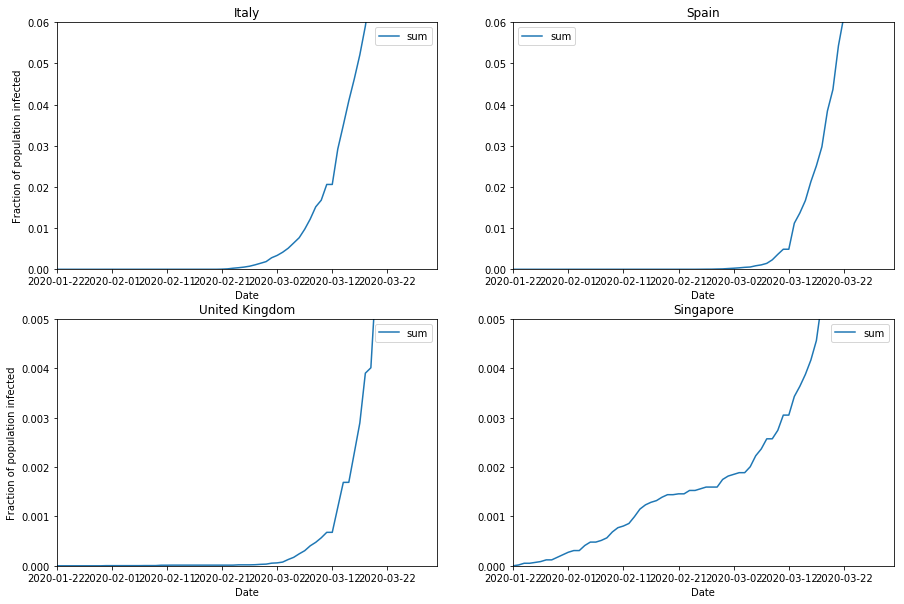

In [7]:
pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_singapore = 5837230.

total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_Singapore.ConfirmedCases = total_date_Singapore.ConfirmedCases/pop_singapore*100.
total_date_Singapore.Fatalities = total_date_Singapore.ConfirmedCases/pop_singapore*100.

plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_Singapore.ConfirmedCases.plot(ax=plt.gca(), title='Singapore')
plt.ylim(0, 0.005)

In order to compare the 4 countries, it's also interesting to see the evolution of the infections from the first confirmed case:

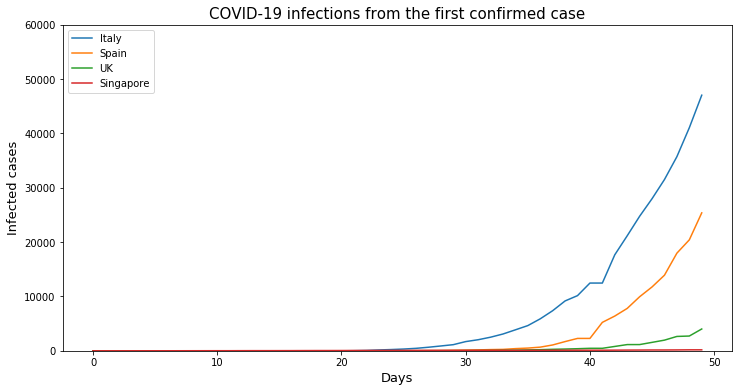

In [8]:
#confirmed_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country_Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

#confirmed_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country_Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

#confirmed_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country_Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

#confirmed_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Australia = train[(train['Country_Region']=='Australia') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Australia = confirmed_total_date_Australia.join(fatalities_total_date_Australia)

#confirmed_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'ConfirmedCases':['sum']})
#fatalities_country_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Country_Region', 'Province_State']).agg({'Fatalities':['sum']})
confirmed_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Singapore = train[(train['Country_Region']=='Singapore') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Singapore = confirmed_total_date_Singapore.join(fatalities_total_date_Singapore)

italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
singapore = [i for i in total_date_Singapore.ConfirmedCases['sum'].values]
singapore_30 = singapore[0:50] 


# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(singapore_30)
plt.legend(["Italy", "Spain", "UK", "Singapore"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()

**Observations**:
* **Italy**. With more than 35.000 confirmed cases, Italy shows one of the most alarming scenarios of COVID-19. The infections curve is very steep, and the percentage of population infected is near the 0.1%
* **Spain**. Spain is the second country from the EU with more confirmed COVID-19 cases, slightly below 15.000 cases. Around 0.03% of the population has currently (2020-03-19) contracted the virus
* **United Kingdom**. Despite not being very far from them, the UK shows less cases. There are several theories for this; @codingdon pointed out in the direction of a lower number of COVID-19 tests, and I think that maybe the Brexit process had an impact into international travels that delayed the arrival of the COVID-19 (baed on [this](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/articles/traveltrends/2018). Anyway, these are just theories and we can't take anything for granted. Only a 0.004% of UK citizens have been reported by COVID-19 infection
* **Singapore**. Singapore is also relatively isolated given that is an island. The number of cases is still very low, despite the general tendency is to increase. However, the infections started faster in the beginning, but the slope of the infections curve hasn't increased very much in the past weeks. There's a 0.005% of population infected

# 2. SIR model <a id="section2"></a>

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR. 

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model, considering birth and death (SIRD with demography), with intermediate states, etc. However, since we are in the early stages of the COVID-19 expansion and our interest is focused in the short term, we will consider that people develops immunity (in the long term, immunity may be lost and the COVID-19 may come back within a certain seasonality like the common flu) and there is no transition from recovered to the remaining two states. With this, the differential equations that govern the system are:

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## 2.1. Implementing the SIR model <a id="section21"></a>

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). For the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system. 

The functions governing the dif.eqs. are:

In [9]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In order to solve the differential equations system, we develop a  4rth order [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method:

In [10]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:

In [11]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

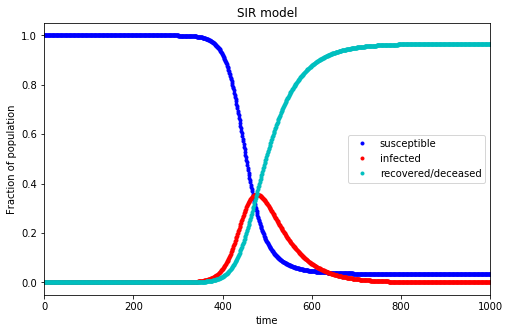

In [12]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**Observations**: 
* The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
* The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
* The oposite happens for the recovered/deceased case

Notice that different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the system.

## 2.2. Fit SIR parameters to real data <a id="section22"></a>

The SIR model is purely theoretical, and we are interested into a real approximation of the COVID-19 expansion in order to extract insights and understand the transmission of the virus. Hence, we need to extract the $\beta$ and $\gamma$ paramaters for each case if we hope to be able to predict the evolution of the system.

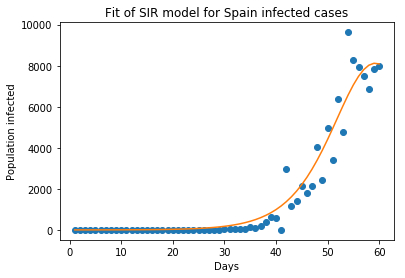

Optimal parameters: beta = 9.603916071603555  and gamma =  9.425449946166948


In [13]:
population = float(46750238)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Spain'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Spain infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

**I'm not happy with the fit of parameters** and I want to work more on this, since I'm not properly reproducing the curves. I'll keep working on this for curiosity, but in the meanwhile I'll develop a data-centric approach to the prediction.

# 3. Data enrichment <a id="section3"></a>

Analyzing SIR simulations was meant to understand a model that approximately resembles the transmission mechanism of many virus, including the COVID-19. However, there are alternative methods that may prove being equally useful both to predict and to understand the pandemic evolution. Many of these methods rely on having rich data to extract conclusions and allow algorithms to extrapolate patterns in data, and that is exactly what we are going to do. 

Main workflow of this section:
1. Join data, filter dates and clean missings
2. Compute lags and trends
3. Add country details

**Disclaimer**: this data enrichment is not mandatory and we could end up not using all of the new features in our models. However I consider it a didactical step that will surely add some value, for example in an in-depth exploratory analysis.

## 3.1. Join data, filter dates and clean missings <a id="section31"></a>

First of all, we perform some pre-processing prepare the dataset, consisting on:

* **Join data**. Join train/test to facilitate data transformations
* **Filter dates**. According to the challenge conditions, remove ConfirmedCases and Fatalities post 2020-03-12. Create additional date columns
* **Missings**. Analyze and fix missing values

In [14]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', 
                 '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)

# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-19', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-19', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province_State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

display(all_data)
display(all_data.loc[all_data['Date'] == '2020-03-19'])

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,2020
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,2020
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,2020
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,2020
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
12637,-1.0,None,Zimbabwe,2020-04-26,0.0,0.0,12638.0,95,26,4,2020
12638,-1.0,None,Zimbabwe,2020-04-27,0.0,0.0,12639.0,96,27,4,2020
12639,-1.0,None,Zimbabwe,2020-04-28,0.0,0.0,12640.0,97,28,4,2020
12640,-1.0,None,Zimbabwe,2020-04-29,0.0,0.0,12641.0,98,29,4,2020


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,Year
0,-1.0,None,Afghanistan,2020-03-19,0.0,0.0,1.0,57,19,3,2020
43,-1.0,None,Albania,2020-03-19,0.0,0.0,44.0,57,19,3,2020
86,-1.0,None,Algeria,2020-03-19,0.0,0.0,87.0,57,19,3,2020
129,-1.0,None,Andorra,2020-03-19,0.0,0.0,130.0,57,19,3,2020
172,-1.0,None,Angola,2020-03-19,0.0,0.0,173.0,57,19,3,2020
...,...,...,...,...,...,...,...,...,...,...,...
12427,-1.0,None,Uzbekistan,2020-03-19,0.0,0.0,12428.0,57,19,3,2020
12470,-1.0,None,Venezuela,2020-03-19,0.0,0.0,12471.0,57,19,3,2020
12513,-1.0,None,Vietnam,2020-03-19,0.0,0.0,12514.0,57,19,3,2020
12556,-1.0,None,Zambia,2020-03-19,0.0,0.0,12557.0,57,19,3,2020


**Observations**: 
* "ConfirmedCases" and "Fatalities" are now only informed for dates previous to 2020-03-12
* The dataset includes all countries and dates, which is required for the lag/trend step
* Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. However, since we will train only on dates previous to 2020-03-12, this won't impact our prediction algorithm
* A new column "Day" has been created, as a day counter starting from the first date

Double-check that there are no remaining missing values:

In [15]:
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
Id              0
Province_State  0
Country_Region  0
Date            0
ConfirmedCases  0
Fatalities      0
ForecastId      0
Day_num         0
Day             0
Month           0
Year            0


## 3.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [16]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.4181976318359375


As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

In [17]:
all_data[all_data['Country_Region']=='Spain'].iloc[40:50][['Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
14670,20941.0,None,Spain,2020-03-02,120.0,0.0,-1.0,40,84.0,45.0,32.0,0.0,0.0,0.0
14671,20942.0,None,Spain,2020-03-03,165.0,1.0,-1.0,41,120.0,84.0,45.0,0.0,0.0,0.0
14672,20943.0,None,Spain,2020-03-04,222.0,2.0,-1.0,42,165.0,120.0,84.0,1.0,0.0,0.0
14673,20944.0,None,Spain,2020-03-05,259.0,3.0,-1.0,43,222.0,165.0,120.0,2.0,1.0,0.0
14674,20945.0,None,Spain,2020-03-06,400.0,5.0,-1.0,44,259.0,222.0,165.0,3.0,2.0,1.0
14675,20946.0,None,Spain,2020-03-07,500.0,10.0,-1.0,45,400.0,259.0,222.0,5.0,3.0,2.0
14676,20947.0,None,Spain,2020-03-08,673.0,17.0,-1.0,46,500.0,400.0,259.0,10.0,5.0,3.0
14677,20948.0,None,Spain,2020-03-09,1073.0,28.0,-1.0,47,673.0,500.0,400.0,17.0,10.0,5.0
14678,20949.0,None,Spain,2020-03-10,1695.0,35.0,-1.0,48,1073.0,673.0,500.0,28.0,17.0,10.0
14679,20950.0,None,Spain,2020-03-11,2277.0,54.0,-1.0,49,1695.0,1073.0,673.0,35.0,28.0,17.0


## 3.3. Add country details <a id="section33"></a>

Variables like the total population of a country, the average age of citizens or the fraction of peoople living in cities may strongly impact on the COVID-19 transmission behavior. Hence, it's important to consider these factors. I'm using [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) based on Web Scrapping for this purpose.

In [18]:
# Load countries data file
world_population = pd.read_csv("/kaggle/input/population-by-country-2020/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'])
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'])
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 
display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4992,50,100,19,10
231,Falkland Islands,3480,0,12170,19,66
232,Niue,1626,6,260,19,46
233,Tokelau,1357,136,10,19,0


Joined dataset


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,None,Afghanistan,2020-01-22,0.0,0.0,-1.0,0,22,1,...,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
1,2.0,None,Afghanistan,2020-01-23,0.0,0.0,-1.0,1,23,1,...,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
2,3.0,None,Afghanistan,2020-01-24,0.0,0.0,-1.0,2,24,1,...,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
3,4.0,None,Afghanistan,2020-01-25,0.0,0.0,-1.0,3,25,1,...,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
4,5.0,None,Afghanistan,2020-01-26,0.0,0.0,-1.0,4,26,1,...,0.0,0.0,0.0,0.0,Afghanistan,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,-1.0,None,Zimbabwe,2020-04-26,0.0,0.0,12638.0,95,26,4,...,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29396,-1.0,None,Zimbabwe,2020-04-27,0.0,0.0,12639.0,96,27,4,...,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29397,-1.0,None,Zimbabwe,2020-04-28,0.0,0.0,12640.0,97,28,4,...,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0
29398,-1.0,None,Zimbabwe,2020-04-29,0.0,0.0,12641.0,98,29,4,...,0.0,0.0,0.0,0.0,Zimbabwe,14862924.0,38.0,386850.0,19.0,38.0


Encoded dataset


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,1.0,79,0,2020-01-22,0.0,0.0,-1.0,0,22,1,...,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
1,2.0,79,0,2020-01-23,0.0,0.0,-1.0,1,23,1,...,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
2,3.0,79,0,2020-01-24,0.0,0.0,-1.0,2,24,1,...,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
3,4.0,79,0,2020-01-25,0.0,0.0,-1.0,3,25,1,...,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
4,5.0,79,0,2020-01-26,0.0,0.0,-1.0,4,26,1,...,0.0,0.0,0.0,0.0,0.0,38928346.0,60.0,652860.0,18.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,-1.0,79,172,2020-04-26,0.0,0.0,12638.0,95,26,4,...,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29396,-1.0,79,172,2020-04-27,0.0,0.0,12639.0,96,27,4,...,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29397,-1.0,79,172,2020-04-28,0.0,0.0,12640.0,97,28,4,...,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0
29398,-1.0,79,172,2020-04-29,0.0,0.0,12641.0,98,29,4,...,0.0,0.0,0.0,0.0,0.0,14862924.0,38.0,386850.0,19.0,38.0


# 4. Predictions with machine learning <a id="section4"></a>

Our obective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. To do so, remember that the challenge specifies that submissions on the public LB shouldn only contain data previous to 2020-03-12.

Models to apply:
1. Linear Regression for one country
2. Linear Regression for all countries (method 1)
3. Linear Regression for all countries (method 2)

## 4.1. Linear Regression for one country <a id="section41"></a>

Since we are interested into predicting the future time evolution of the pandemic, our first approach consists on a simple Linear Regression. However, remind that the evolution is not linear but exponential (only in the beginning of the infection), so that a preliminar log transformation is needed. 

Visual comparison of both cases for Spain and with data from last 10 days informed, starting on March 1st:

Text(0, 0.5, 'Log ConfirmedCases')

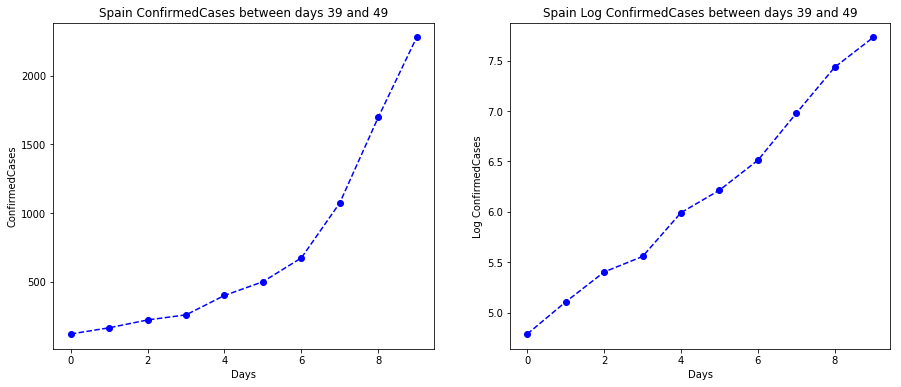

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Day_num = 38 is March 1st
y1 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases between days 39 and 49")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[(all_data['Country_Region']==country_dict['Spain']) & (all_data['Day_num']>39) & (all_data['Day_num']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases between days 39 and 49")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

As you see, the log transformation results in a fancy straight-like line, which is awesome for Linear Regression. However, let me clarify two important points:

* This "roughly exponential behavior" is only true for the initial infection stages of the pandemic (the initial increasing of infections on the SIR model), but that's exactly the point where most countries are at the moment.

* Why do I only extract the last 10 days of data? For three reasons:
    1. In order to capture exactly the very short term component of the evolution
    2. To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation)
    3. To prevent differences on criteria when confirming cases (remember that weird slope on the China plot?)

This first model is very simple, and only elemental features will be considered: Country/Region, date information, Long and Lat. Lags. Engineered columns like lags, trends and country details are not introduced as an input. Finally, the workflow for the Basic Linear Regression model is:
1. **Features**. Select features
2. **Dates**. Filter train data from 2020-03-01 to 2020-03-18
2. **Log transformation**. Apply log transformation to ConfirmedCases and Fatalities
3. **Infinites**. Replace infinites from the logarithm with 0. Given the asymptotic behavior of the logarithm for log(0),this implies that when applying the inverse transformation (exponential) a 1 will be returned instead of a 0. This problem does not impact many countries, but still needs to be tackled sooner or later in order to obtain a clean solution.
4. **Train/test split**. Split into train/valid/test
5. **Prediction**. Linear Regression, training country by country and joining data
6. **Submit**. Submit results in the correct format, and applying exponential to reverse log transformation 

In [20]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 
       'Day_num']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

Let's try to see results when training with a single country:

* **Spain**

In [21]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', 
                 '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']

In [22]:
all_data.loc[all_data['Country_Region']==country_dict['Spain']][40:65]

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ForecastId,Day_num,Day,Month,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
11953,20941.0,79,147,2020-03-02,120.0,0.0,-1.0,40,2,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11954,20942.0,79,147,2020-03-03,165.0,1.0,-1.0,41,3,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11955,20943.0,79,147,2020-03-04,222.0,2.0,-1.0,42,4,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11956,20944.0,79,147,2020-03-05,259.0,3.0,-1.0,43,5,3,...,2.000000,0.000000,0.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11957,20945.0,79,147,2020-03-06,400.0,5.0,-1.0,44,6,3,...,1.500000,4.000000,0.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11958,20946.0,79,147,2020-03-07,500.0,10.0,-1.0,45,7,3,...,2.333333,4.000000,9.000000,0.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11959,20947.0,79,147,2020-03-08,673.0,17.0,-1.0,46,8,3,...,2.400000,4.666667,7.500000,16.000000,0.000000,46754778.0,94.0,498800.0,45.0,80.0
11960,20948.0,79,147,2020-03-09,1073.0,28.0,-1.0,47,9,3,...,1.800000,4.600000,8.333333,13.000000,27.000000,46754778.0,94.0,498800.0,45.0,80.0
11961,20949.0,79,147,2020-03-10,1695.0,35.0,-1.0,48,10,3,...,1.058824,2.500000,6.000000,10.666667,16.500000,46754778.0,94.0,498800.0,45.0,80.0
11962,20950.0,79,147,2020-03-11,2277.0,54.0,-1.0,49,11,3,...,0.928571,2.176471,4.400000,9.800000,17.000000,46754778.0,94.0,498800.0,45.0,80.0


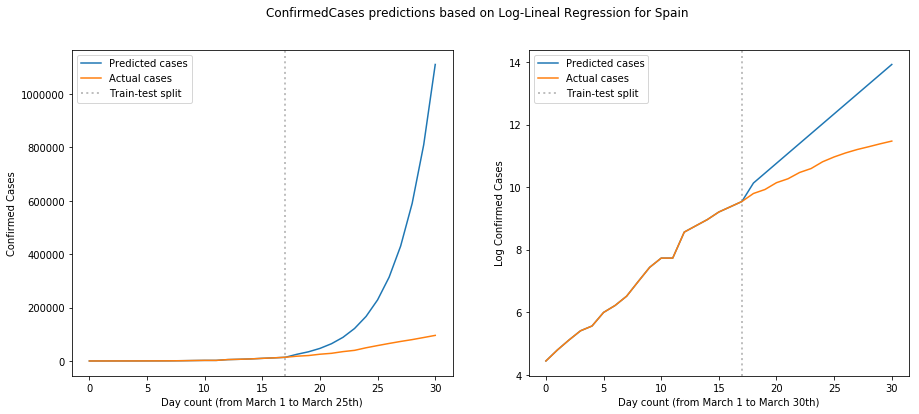

In [23]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions (predictions starting on March 12th)
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    X_test_check = X_test.copy()
    X_test_check['Target'] = pred

    X_final_check = pd.concat([X_train_check, X_test_check])

    # Select predictions from March 1st to March 25th
    predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(17-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (from March " + str(1+shift) + " to March 25th)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(17-shift, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (from March " + str(1+shift) + " to March 30th)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
    
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 0
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

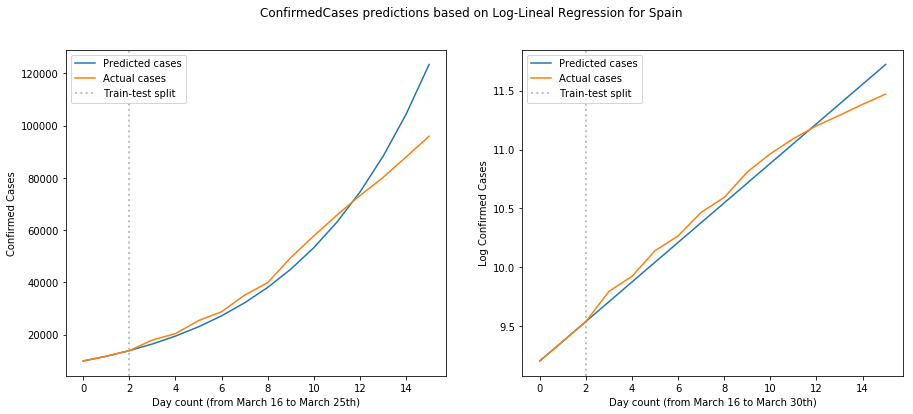

In [24]:
# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
march_day = 15
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

* **Italy**

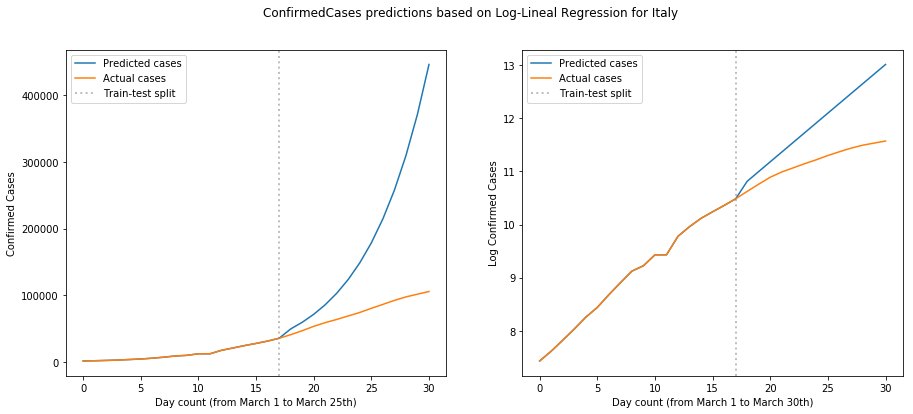

In [25]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 0
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

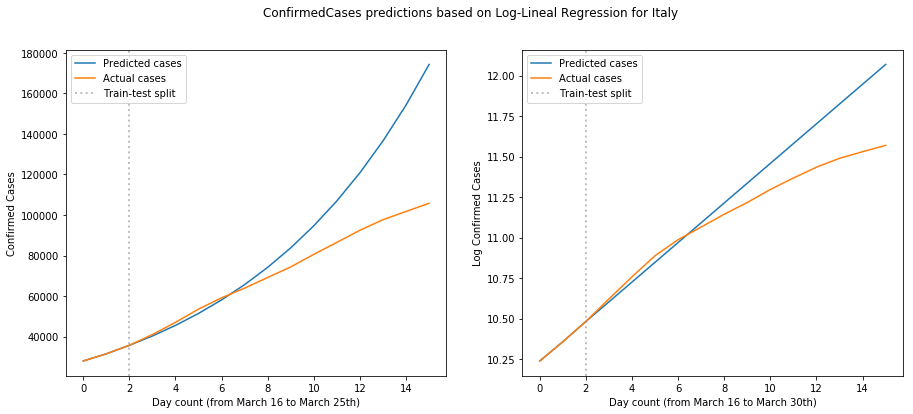

In [26]:
# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
march_day = 15
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

* **Germany**

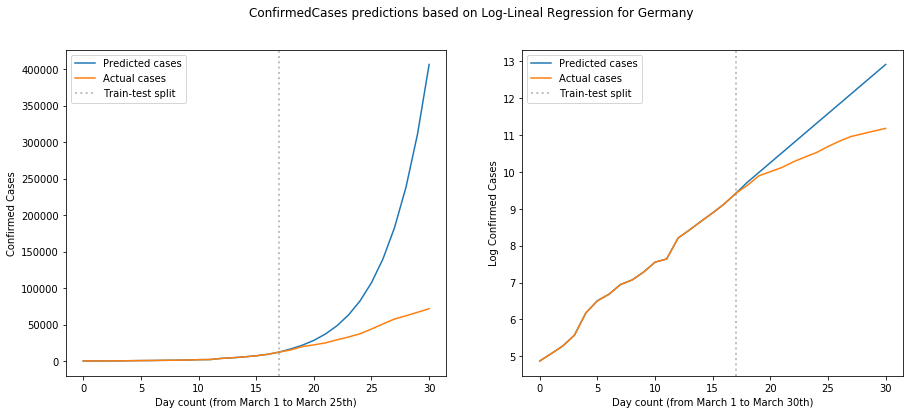

In [27]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 0
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

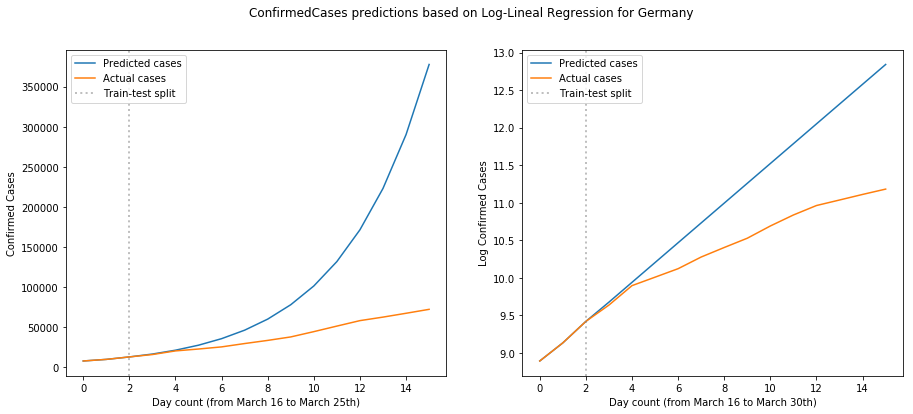

In [28]:
# Filter Germany, run the Linear Regression workflow
country_name = "Germany"
march_day = 15
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

* **Albania**

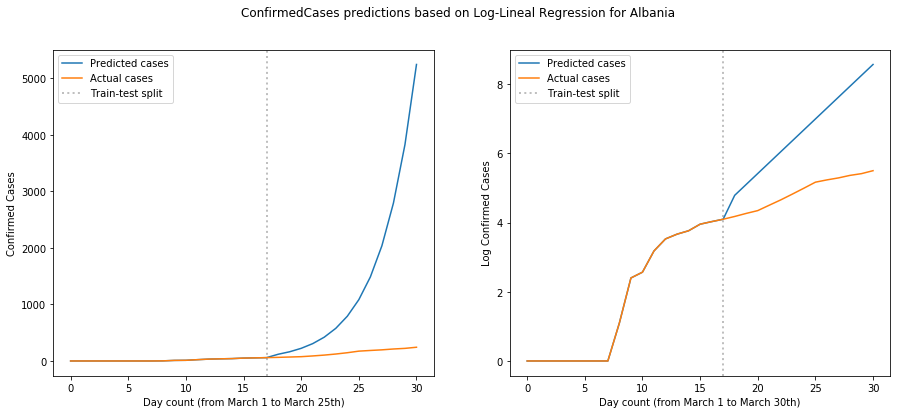

In [29]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 0
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

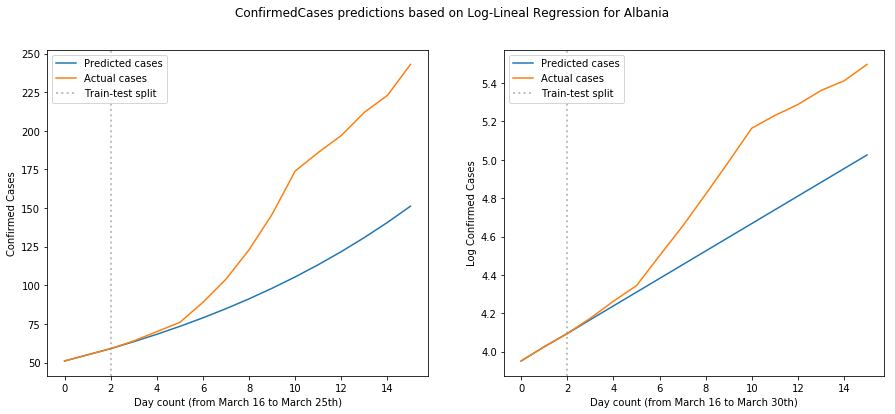

In [30]:
# Filter Albania, run the Linear Regression workflow
country_name = "Albania"
march_day = 15
day_start = 39+march_day
dates_list2 = dates_list[march_day:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, march_day)

* **Andorra**

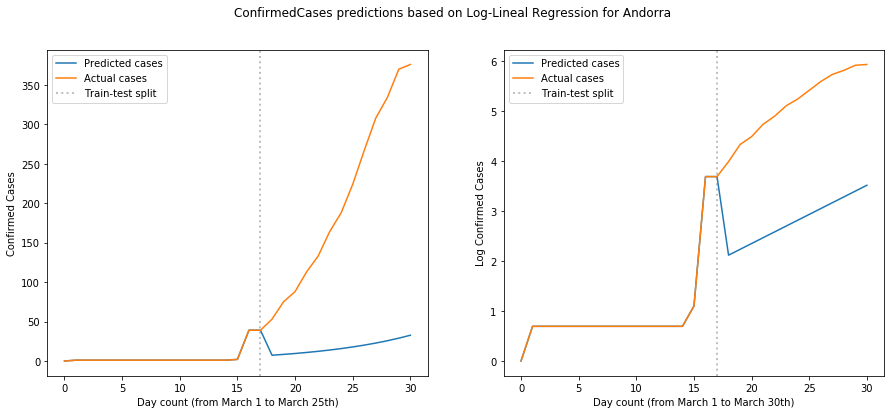

In [31]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 0
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift)

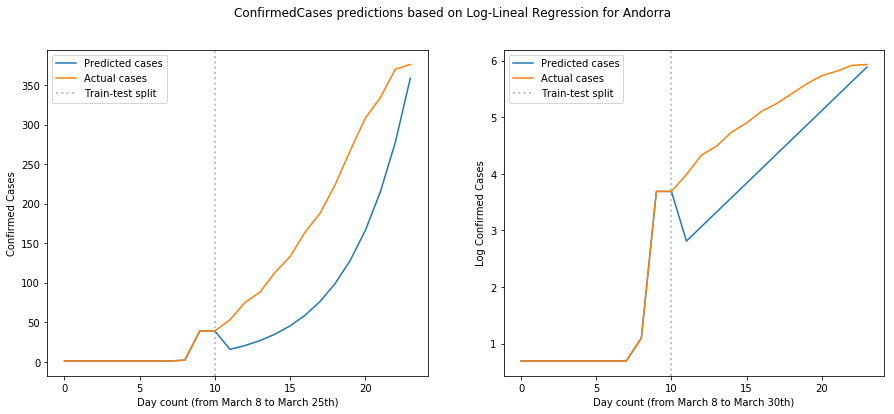

In [32]:
# Filter Andorra, run the Linear Regression workflow
country_name = "Andorra"
shift = 7
day_start = 39+shift
dates_list2 = dates_list[shift:]
plot_linreg_basic_country(data, country_name, dates_list2, day_start, shift)

**Observations**:

* The general evolution is captured despite the simplicity of the model
* Each country shows an optimal number of previous days in order to train to obtain the best results. When using training data from March 1st, results are good for Spain, Italy and Germany (large number of cases) but quite bad for Albania or Andorra (where the COVID-19 outbrake started later). 
* Estimations are increasingly worse as time passes (harder to extrapolate)
* Countries that recently confirmed their first contagions are difficult to predict (less data points) 
* Countries with 0 cases in the whole training dataset are predicted as non-infected (no datapoints)

** Questions to tackle in next subsections**:
* How to obtain the full submission set? 
* What to do for countries with different Provinces/State informed?
* Is there any alternative to manually setting the size of the train data? 

## 4.2 Logistic Regression for all countries (method 1) <a id="section42"></a>

We've recently discovered that when fitting only with 10 historical datapoints some problematic scenarios appear, that impact the performance of our Linear Regressor. Let's generalize the model for all countries to verify if it's an unavoidable problem. Steps to run for all countries:

1. Loop for each country
2. Compute provinces list
3. If there are provinces, run the Linear Regressor for each of them
4. Otherwise just run the Linear Regressor

In [33]:
ts = time.time()

def linreg_basic_all_countries(data, day_start):
    
    data2 = data.loc[data.Day_num >= day_start]

    # Set the dataframe where we will update the predictions
    data_pred = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
    data_pred = data_pred.loc[data_pred['Day_num']>=day_start]
    data_pred['Predicted_ConfirmedCases'] = [0]*len(data_pred)
    data_pred['Predicted_Fatalities'] = [0]*len(data_pred)

    print("Currently running Logistic Regression for all countries")

    # Main loop for countries
    for c in data2['Country_Region'].unique():

        # List of provinces
        provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()

        # If the country has several Province/State informed
        if len(provinces_list)>1:
            for p in provinces_list:
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred.loc[((data_pred['Country_Region']==c) & (data2['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

        # No Province/State informed
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred.loc[(data_pred['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

    # Apply exponential transf. and clean potential infinites due to final numerical precision
    data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
    data_pred.replace([np.inf, -np.inf], 0, inplace=True) 
    
    return data_pred


day_start = 52
data_pred = linreg_basic_all_countries(data, day_start)
get_submission(data_pred, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  11.16  seconds


Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.19681**

## 4.3 Logistic Regression for all countries (method 2) <a id="section43"></a>

An alternative method to setting the number of days for the training step is to simply keep all data for each country since the first case was confirmed. However, since there are certain countries were the initial outbreak was very smooth (i.e. in Spain there was only one confirmed case for 7 days in a row), predictions may be biased by these initial periods.

In [34]:
ts = time.time()

# Set the dataframe where we will update the predictions
data2 = data.loc[data.Day_num >= day_start]
data_pred3 = data[data.ForecastId != -1][['Country_Region', 'Province_State', 'Day_num', 'ForecastId']]
data_pred3['Predicted_ConfirmedCases'] = [0]*len(data_pred3)
data_pred3['Predicted_Fatalities'] = [0]*len(data_pred3)
how_many_days = test.Date.nunique()
    
print("Currently running Logistic Regression for all countries")

# Main loop for countries
for c in data['Country_Region'].unique():
    
    # List of provinces
    provinces_list = data2[data2['Country_Region']==c]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        
        for p in provinces_list:
            # Only fit starting from the first confirmed case in the country
            train_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
            test_countries_no0 = data.loc[(data['Country_Region']==c) & (data['Province_State']==p) &  (data.ForecastId!=-1)]
            data2 = pd.concat([train_countries_no0, test_countries_no0])

            # If there are no previous cases, predict 0
            if len(train_countries_no0) == 0:
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
                data_pred3.loc[((data_pred2['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = [0]*how_many_days
                
            # Else run LinReg
            else: 
                data_cp = data2[(data2['Country_Region']==c) & (data2['Province_State']==p)]
                X_train, Y_train_1, Y_train_2, X_test = split_data(data_cp)
                model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
                model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_ConfirmedCases'] = pred_1
                data_pred3.loc[((data_pred3['Country_Region']==c) & (data_pred3['Province_State']==p)), 'Predicted_Fatalities'] = pred_2

    # No Province/State informed
    else:
        # Only fit starting from the first confirmed case in the country
        train_countries_no0 = data.loc[(data['Country_Region']==c) & (data.ConfirmedCases!=0) & (data.ForecastId==-1)]
        test_countries_no0 = data.loc[(data['Country_Region']==c) &  (data.ForecastId!=-1)]
        data2 = pd.concat([train_countries_no0, test_countries_no0])

        # If there are no previous cases, predict 0
        if len(train_countries_no0) == 0:
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_ConfirmedCases'] = [0]*how_many_days
            data_pred3.loc[((data_pred3['Country_Region']==c)), 'Predicted_Fatalities'] = [0]*how_many_days
        
        # Else, run LinReg
        else:
            data_c = data2[(data2['Country_Region']==c)]
            X_train, Y_train_1, Y_train_2, X_test = split_data(data_c)
            model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
            model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_ConfirmedCases'] = pred_1
            data_pred3.loc[(data_pred3['Country_Region']==c), 'Predicted_Fatalities'] = pred_2

# Aplly exponential transf. and clean potential infinites due to final numerical precision
data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']] = data_pred3[['Predicted_ConfirmedCases', 'Predicted_Fatalities']].apply(lambda x: np.expm1(x))
data_pred3.replace([np.inf, -np.inf], 0, inplace=True) 

#get_submission(data_pred3, 'Predicted_ConfirmedCases', 'Predicted_Fatalities')

print("Process finished in ", round(time.time() - ts, 2), " seconds")

Currently running Logistic Regression for all countries
Process finished in  5.0  seconds


From my experiments, this apporach is not suitable for our linear regression model. In many cases there are strong transitional periods at the beginning, which frequently biases the regression. Hence, I will not apply this method on following sections, but you are welcome to use it for any other purposes.

Final [LMSE score](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) for week 2, with training data prior to 2020-03-19 and measures on date 2020-04-01: 

**1.62190**

## 4.4. Logistic regression with lags <a id="section44"></a>

With all the previous results in mind, I quite believe that Linear Regression is a good approach for the early stages of the COVID-19 spread. Of course, this is only true for the initial outbreak we are analysing, and there's no way our model could predict when the number of new infections is going to decrease. But for short-term prediction purposes everything is fine, and we are in disposition to try to improve the results.

Remember those lagged variables we computed some sections before? Now it's time to use them, but first there's a problem to solve. If we use our dataset to predict the next following days of contagions, for the first day all the lags will be reported (from the previous days), but what about the next days? **Many of the lags will be unknown** (flagged as 0), since the number of ConfirmedCases is only known for the train subset. The most simple approach to overcome this is:

1. Begin with the train dataset, with all cases and lags reported
2. Forecast only the following day, through the Linear Regression
3. Set the new prediction as a confirmed case
4. Recompute lags
5. Repeat from step 2 to step 4 for all remaining days

As usual, I'll start training on single countries in order to analyze the behavior of the model with these new features.

In [35]:
# New split function, for one forecast day
def split_data_one_day(data, d):
    
    #Train
    x_train = data[data.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = data[data.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(17-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + "))")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(17-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list, march_day):

    # Select predictions from March 1st to March 25th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(17-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.axvline(17-march_day, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March " + str(march_day) + ")")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Log-Lineal Regression for "+country_name))

* **Spain**

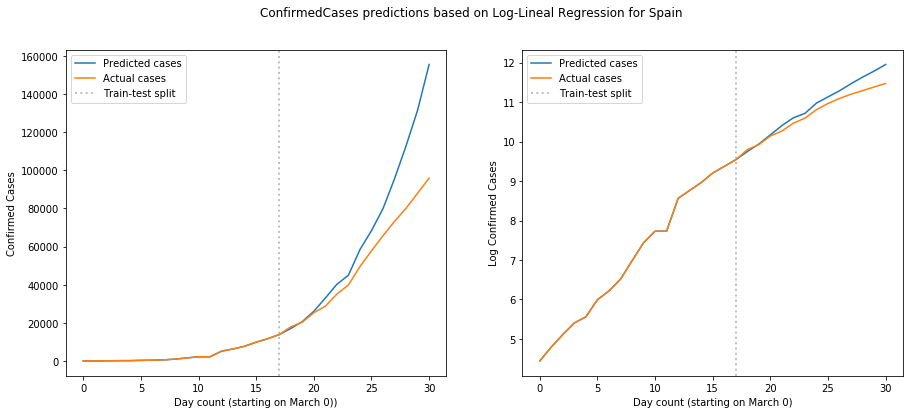

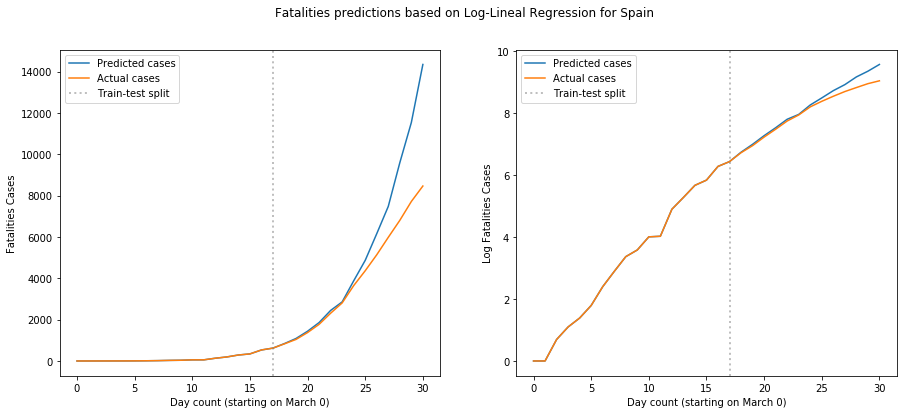

In [36]:
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country_Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province_State', 'Country_Region',
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log1p(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country_Region']==country_dict[country_name]) & (data['Province_State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    #print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data



# Run the model for Spain
country_name = 'Spain'
march_day = 0
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Italy**

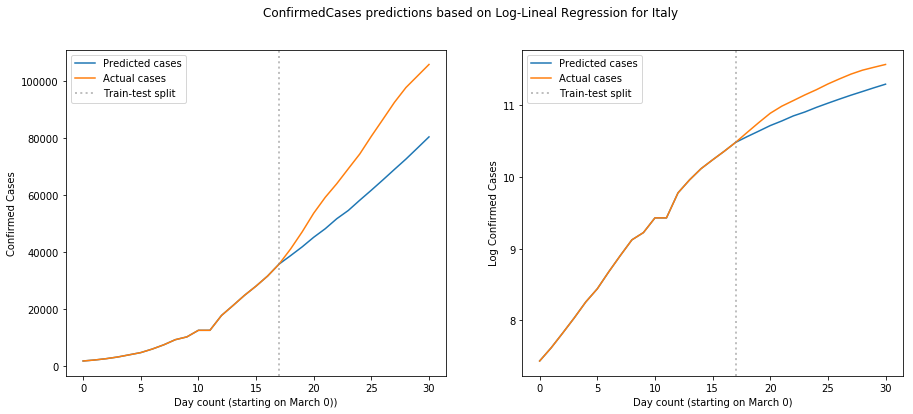

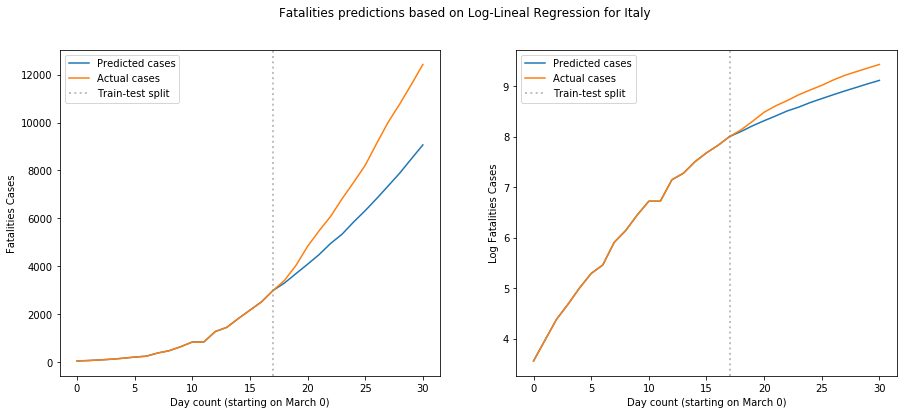

In [37]:
ts = time.time()

# Inputs
country_name = "Italy"
march_day = 0
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Germany**

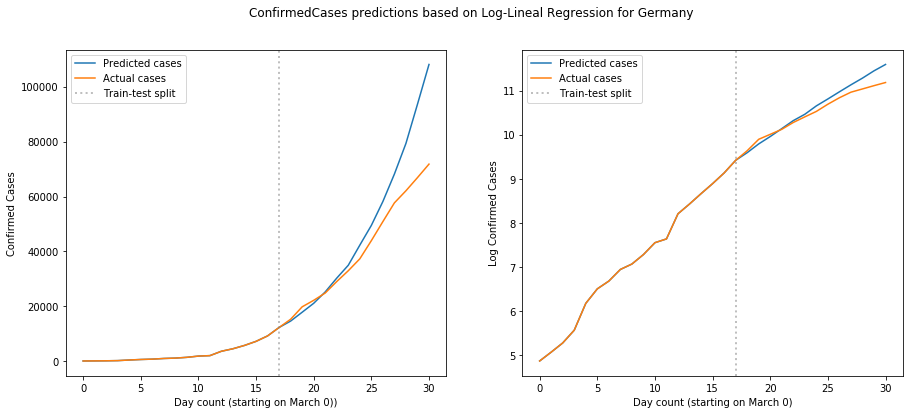

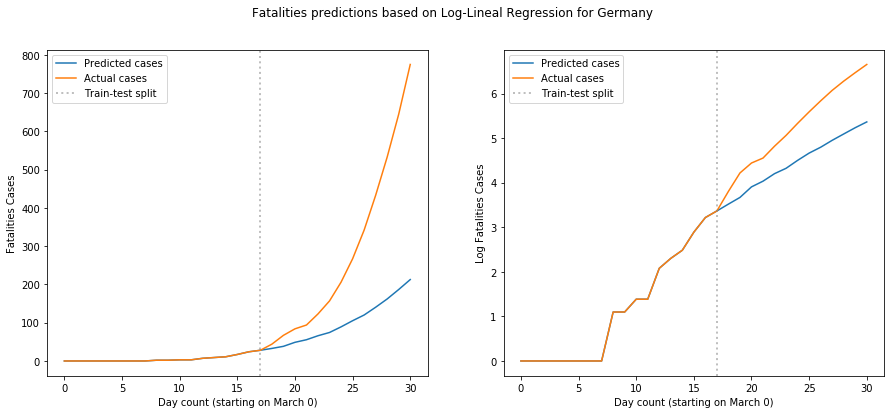

In [38]:
# Inputs
country_name = "Germany"
march_day = 0
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 30

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Albania**

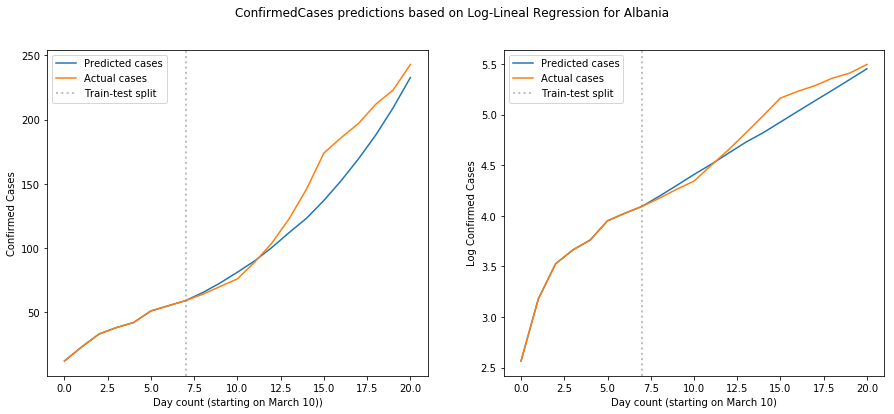

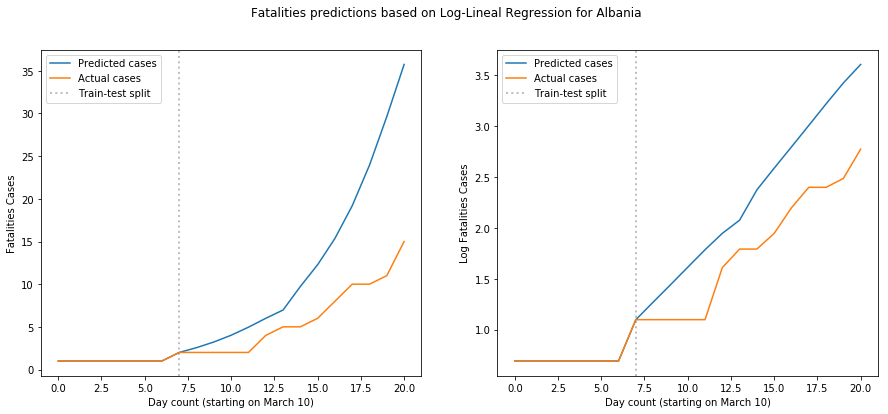

In [39]:
# Inputs
country_name = "Albania"
march_day = 10
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 7

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

* **Andorra**

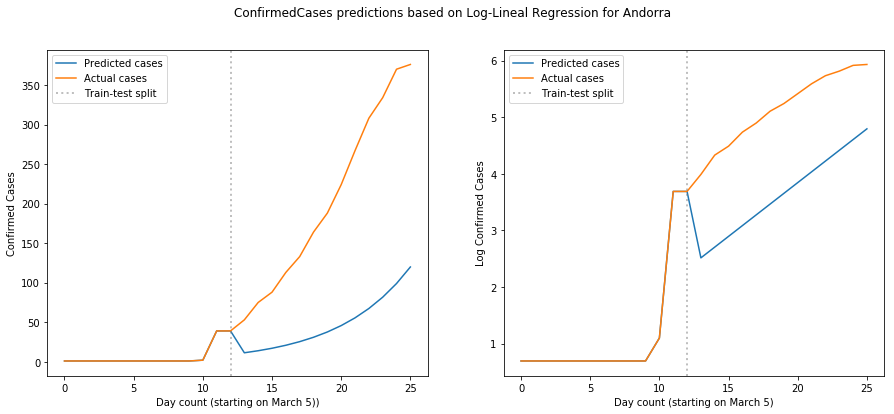

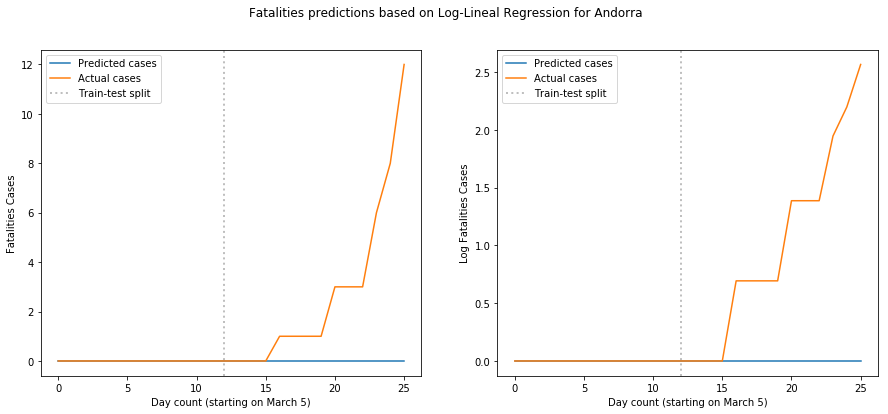

In [40]:
# Inputs
country_name = "Andorra"
march_day = 5
day_start = 39 + march_day
dates_list2 = dates_list[march_day:]
lag_size = 1

data_c = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data_c, train, country_name, day_start, dates_list2, march_day)
plot_real_vs_prediction_country_fatalities(data_c, train, country_name, day_start, dates_list2, march_day)

**Observations**:
* **Parameters**. Two full weeks of training used (from February 26th to March 11th), with their previous 30 lags
* **Enough data**. (Spain, Italy, Germany). For countries with several ConfirmedCases!=0 in the train dataset (prior to March 11th), predictions are very precise and similar to actual confirmed data
* **Poor data**. (Algeria, Andorra). Countries with a small number of datapoints in the train dataset show a potentially disastrous prediction. Given the small number of cases, the log transformation followed by a Linear Regression is not able to capture the future behavior
* **No data**. When the number of confirmed cases in the train dataset is 0 or negligible, the model predicts always no infections

Let's generalize the model with lags for training each country day by day:

In [41]:
# Inputs
day_start = 39 
lag_size = 30

train3 = train.copy()
train3.Province_State.fillna("None", inplace=True)

results_df = pd.DataFrame()

tp = time.time()

# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()
        
    # If the country has several Province/State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
            pred_province = lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict)
            results_df = pd.concat([results_df, pred_province])

    else:
        pred_country = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
        results_df = pd.concat([results_df, pred_country])
        
results_df_submit = results_df.copy()
results_df_submit['ConfirmedCases'] = results_df_submit['ConfirmedCases'].apply(lambda x: np.expm1(x))
results_df_submit['Fatalities'] = results_df_submit['Fatalities'].apply(lambda x: np.expm1(x))
        
#get_submission(results_df_submit.loc[results_df_submit['ForecastId']!=-1], 'ConfirmedCases', 'Fatalities')
print("Complete process finished in ", time.time()-tp)

Complete process finished in  566.9035108089447


Nice, extending the model for all countries and days has been quite easy, but a tricky part needs to be addressed. As we saw when analyzing the results for certain countries, some of them have too few training datapoints different from 0, and these scenarios sometimes end up with the regression algorithm predicting absurd values.  

For the sake of simplicity, my proposal to overcome this problem consists on mixing the current results with those from [section 4.2.](#section42), where we trained the model for all countries without lags. All countries with too few confirmed cases in the training dataset will be predicted with results from section 4.2.

In [42]:
results_df_2 = results_df.copy()

day_start = 39
data_pred2 = linreg_basic_all_countries(data, day_start)
day_num_test = 57    # Day 2020-04-18


# Main loop for countries
for country_name in train3['Country_Region'].unique():

    # List of provinces
    provinces_list = train3[train3['Country_Region']==country_name]['Province_State'].unique()

    # Countries with several Province_State informed
    if len(provinces_list)>1:
        for province_name in provinces_list:
        
            tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Province_State']==province_dict[province_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

            # When there is not enough data
            if len(tmp_index) < 30:
                
                # ConfirmedCases
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
                
                #Fatalities
                results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                                  (results_df_2['Province_State']==province_dict[province_name]) &
                                  (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                                  (data_pred2['Province_State']==province_dict[province_name]) & 
                                  (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
                
    # Countries without Province_State
    else:
        tmp_index = all_data.index[(all_data['Country_Region']==country_dict[country_name]) & 
                           (all_data['Day_num']<day_num_test) & 
                           (all_data['ConfirmedCases']!=0)]

        # When there is not enough data
        if len(tmp_index) < 30:
            
            #Confirmed Cases
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'ConfirmedCases'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_ConfirmedCases'].apply(lambda x: np.log1p(x))
            
            results_df_2.loc[((results_df_2['Country_Region']==country_dict[country_name]) & 
                            (results_df_2['Day_num']>=day_num_test)), 'Fatalities'] = data_pred2.loc[((data_pred2['Country_Region']==country_dict[country_name]) & 
                            (data_pred2['Day_num']>=day_num_test)), 'Predicted_Fatalities'].apply(lambda x: np.log1p(x))
            
results_df_2 = results_df_2.loc[results_df_2['Day_num']>=day_num_test]
#results_df_2[['ConfirmedCases', 'Fatalities']] = results_df_2[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.expm1(x))
#get_submission(results_df_2, 'ConfirmedCases', 'Fatalities')

Currently running Logistic Regression for all countries


## 5. Statement of the author <a id="section5"></a>


* The **objective of this notebook** is to provide some insights about the COVID-19 transmission from a data-centric perspective in a didactical and simple way. Predicted results **should not be considered in any way an affirmation of what will happen in the future**. Observations obtained from data exploration are personal opinions.


* Models tailored specifically for epidemic spreading (i.e. SIR and its versions) are designed to reproduce a certain phenomenology, in order to understand the underlying mechanics of a contagion process. On the other hand, the simple machine learning approaches I used aim to predict the short term evolution of the infection in the current regime. They might eventually help to find some features or parameters that are particularly important for the model’s fitting, but by no means they should be confused with scientific epidemic models. 


* The success of the current predictions is **strongly dependent on the current spreading regime**, in which the number of infections is still increasing exponentially for many countries. However, they cannot provide a reliable expected day by which the maximum contagion peak will be reached. Epidemic models are closer to obtaining such estimations, but there’s a large number of variables that need to be considered for this (quarantines, quality of the medical resources deployed, environmental measures…).


* In order to achieve such results, a considerable amount of **tuning is required**. We filter how many previous dates should be used for the fitting step, when to use lags or not, and even missings replacements were very rough due to the log transformation. 


* **Predictive models** can be used for several purposes, but they **never** (try to) **substitute  recommendations from experts**. 

In [43]:
# ALTERNATIVE FUNCTIONS FOR FURTHER ANALYSIS

# LGB Regressor 
"""
model=lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        #min_child_weight=300,
        #num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=16,
        #reg_alpha=0.04,
        #reg_lambda=0.073,
        #min_split_gain=0.0222415,
        verbose=1,
        seed=21)

model.fit(X_train, Y_train_1, eval_metric="rmse", eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)], verbose=1, early_stopping_rounds = 20)

Y_test = model.predict(X_test)
"""


# Show Spain enriched data
"""
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]
train[(train['Country/Region']=='Spain') & (train['Date']=='2020-03-12')]
data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']==49)]['ConfirmedCases'].apply(lambda x: np.exp(x))
"""


# XGB Regressor
"""
reg = xgb.XGBRegressor()
reg.fit(X_train, Y_train_1,
        eval_set=[(X_train, Y_train_1), (X_valid, Y_valid_1)],
        early_stopping_rounds=50,
       verbose=True)

_ = plot_importance(reg, height=0.9, max_num_features=20)
Y_pred = reg.predict(X_valid)
print(Y_pred)
"""


# XGB GridSearch
"""
ts = time.time()

xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.07, .01, .005], #so called `eta` value
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [4, 5, 6, 7],
              'silent': [0],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, Y_train_1)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Y_pred = xgb_grid.predict(X_valid)
print(Y_pred, Y_valid_1)

print("Time spent: ", ts-time.time())
"""


# Some plots
"""
plt.plot(data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']<=49)]['ConfirmedCases'])

y = data[(data['Lat']==40.0) & (data['Long']==-4.0) & (data['Day']> 35) & (data['Day']<=49)][['ConfirmedCases']].apply(lambda x: np.log(x))
x = range(0, len(y))
plt.plot(x, y, 'go--')
"""


# Linear Regression
"""
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train_1)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Compute mean squared error on real values (inverse transform of log)
#rms = mean_squared_error(Y_test_1.apply(lambda x: np.exp(x)).astype('int16'), np.exp(y_pred).astype('int16'))
#print("Mean squared error: ", rms)
"""

# LGB 2
"""
def lgb_reg(X_train, Y_train_1, X_test):
    # Create linear regression object
    regr = lgb.LGBMRegressor(n_estimators=1000)

    # Train the model using the training sets
    regr.fit(X_train, Y_train_1, eval_metric="rmse")

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred
"""


# Predictions
"""
#Predictions
X_test_compare = X_test.copy()
X_test_compare['PredictedCases'] = y_pred_xgb
X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73)]

# Train test
compare = train.loc[train['Date'].isin(dates_overlap)]
compare = compare.merge(test[['Country/Region', 'Date', 'ForecastId']], on=['Country/Region', 'Date'])
#compare['PredictedCases'] = X_test_compare.loc[(X_test_compare['Day']>=50) & (X_test_compare['Day']<73), 'PredictedCases']
compare

# Total comparison
total_compare = X_test_compare.join(compare, on='ForecastId', rsuffix='X_compare')
total_compare[['ForecastId', 'Country/Region', 'ConfirmedCases', 'PredictedCases']]
"""


# More plots for LinReg (all countries)
"""
# Select predictions from March 1st to March 22nd

predicted_data = data_pred.loc[(data_pred['Country/Region']==1)].Predicted_ConfirmedCases[:11]

dates_list = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22']
real_data = train.loc[(train['Country/Region']=='Albania') & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, predicted_data)
ax1.plot(dates_list_num, real_data)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, np.log(predicted_data))
ax2.plot(dates_list_num, np.log(real_data))
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")
"""

# ARIMA
"""
# definir conjunto de datos
x = df_mon_to_fri

# instanciar modelo
sarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 24))

# ajustar modelo
results = sarima_model.fit()

# mirar el AIC
results.aic
"""

'\n# definir conjunto de datos\nx = df_mon_to_fri\n\n# instanciar modelo\nsarima_model = SARIMAX(x, order=(2,0,1), seasonal_order=(2, 1, 0, 24))\n\n# ajustar modelo\nresults = sarima_model.fit()\n\n# mirar el AIC\nresults.aic\n'